# Setup

In [ ]:
# want version 3.4
!pip install --upgrade matplotlib 

In [1]:
#@title ## Basic imports

import sys
print(sys.version)
import importlib  # for reloading imports to source functions
#from IPython.display import HTML, Math
import IPython.display
import os
import time

import itertools
import inspect 
import math

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections

import warnings
warnings.simplefilter("default")
#warnings.simplefilter('error'). # throws all warnings as errors
# How to display stack traces, options: Plain, Context (default), Verbose
%xmode Context 
# Turn on or off to cause debug mode to auto enter if exception is thrown
%pdb off

# Below code allows latex to be formatted nicely as google colab output
# Source: https://stackoverflow.com/a/61876185/2879686
def load_mathjax_in_cell_output():
  display(IPython.display.HTML("<script src='https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register("pre_run_cell", load_mathjax_in_cell_output)

# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Exception reporting mode: Context
Automatic pdb calling has been turned OFF


In [2]:
#@title ## Mount google drive and import my code

try:
    from google.colab import drive
    # Need to move out of google drive directory if going to remount
    %cd
    # drive.mount documentation can be accessed via: drive.mount?
    #Signature: drive.mount(mountpoint, force_remount=False, timeout_ms=120000, use_metadata_server=False)
    mountpoint_folder_name = "gdrive"  # can be anything, doesn't have to be drive
    drive.mount(os.path.join("/content/",mountpoint_folder_name), force_remount=True)  # mounts to a folder called mountpoint_folder_name
    new_path = os.path.join("/content/",mountpoint_folder_name,
                            "MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src")
    if new_path not in sys.path:
        pass
        #sys.path.insert(0,new_path)
    %cd "/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src"
    #%cd "/content/gdrive"
    
except ModuleNotFoundError:  # in case not run in Google colab
    import traceback
    traceback.print_exc()


#from src.inverting import euler_inversion
#from src import plotting
#from src import viscoporoelastic_model
#from src.viscoporoelastic_model import ViscoporoelasticModel
#from inverting import euler_inversion
import inverting
import plotting
import viscoporoelastic_model
from viscoporoelastic_model import CohenModel


<IPython.core.display.Javascript object>

/root
Mounted at /content/gdrive
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src


/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
#@title ## Specific imports for bessel functions

# Numpy besseli (i0) function doesn't support complex values and only has order 0
def I0(x):      return sp.special.iv(0, x) #return np.i0(x); #besseli(0, x)
def I1(x):      return sp.special.iv(1, x) #besseli(1, x)
def Iv(x,v):    return sp.special.iv(v, x)
def J0(x):      return sp.special.jv(0, x)
def J1(x):      return sp.special.jv(1, x)
def Jv(x,v):    return sp.special.jv(v, x)
def ln(x):      return np.log(x)  #import math #return math.log(x)


<IPython.core.display.Javascript object>

$
\renewcommand{\Re}{\operatorname{Re}}
\renewcommand{\Im}{\operatorname{Im}}
$  
# Define $\Im{z}$ and $\Re{z}$ operators of complex numbers
The default Im and Re are hard to read and it is cumbersum to do \operatorname{Re} or \mathrm{Re} every time.a



In [4]:
#@title Define functions to modify complex output to plottable values
def ychange(vals, return_name=False, scale_logp=False):
    if plot_y_comp in [1j, -1, -1j]:
        vals = np.imag(vals)
        name = "Imag component"
    elif plot_y_comp == 1:
        vals = np.real(vals)
        name = "Real component"
    elif plot_y_comp == np.inf: # shows the component closer to 0
        vals_ind = np.argmin( [np.abs(np.real(vals)), np.abs(np.imag(vals))], axis=0 )
        vals = np.where(vals_ind, np.real(vals), np.imag(vals))
        name = "Component closer to 0"
    elif np.abs(plot_y_comp-np.pi) <= 0.01:  # plots the angle
        vals = np.angle(vals)
        name = "Angle component"
    else:
        vals = np.absolute(vals)
        name = "Magnitude"
    if return_name:
        return name
    elif scale_logp:
        return np.log1p(np.abs(vals))
    else:
        return vals   



def complex_array_to_rgb(X, theme='light', rmax=None):
    """Takes an numpy matrix/array of complex numbers and converts it to an 
    matrix with an addition dimension so that the value at any index goes from a single complex 
    number to a 3-dim numpy array of [r, g, b].
    Phase gives hue and saturaton/value are given by the absolute value.
    Especially for use with imshow for complex plots.
    # https://stackoverflow.com/questions/15207255/is-there-any-way-to-use-bivariate-colormaps-in-matplotlib

    """
    # Have a max so all values are 0.0≤x≤1.0 
    absmax = rmax or np.nanmax(np.abs(X))
    # If X has shape of (2,3,4), then Y has shape of (2,3,4,3)
    Y = np.zeros(X.shape + (3,), dtype='float')
    Y[..., 0] = np.angle(X) / (2 * np.pi) % 1
    if theme == 'light':
        Y[..., 1] = np.clip(np.abs(X) / absmax, 0, 1)
        Y[..., 2] = 1
    elif theme == 'dark':
        Y[..., 1] = 1
        Y[..., 2] = np.clip(np.abs(X) / absmax, 0, 1)
    Y = matplotlib.colors.hsv_to_rgb(Y)
    return Y

<IPython.core.display.Javascript object>

# Real input plots

<IPython.core.display.Javascript object>

[-890.17+0.j    0.  +0.j]
[-757.98-0.j    0.  +0.j]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new inst

(-30.0, 50.0)

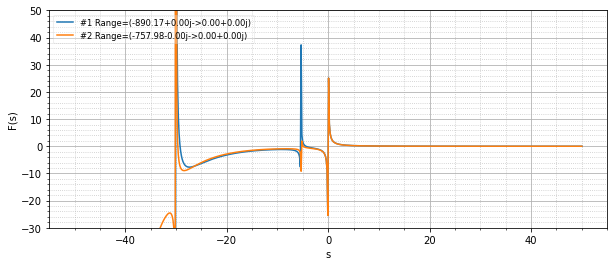

In [ ]:
#@title Compare Cohen laplace versions (either direct or forward transform of time)

from viscoporoelastic_model import CohenModel, CohenModel1998
importlib.reload(inverting)
importlib.reload(viscoporoelastic_model)

def getCohenModelModified(**kwargs):
    class CohenModelModified(CohenModel):
        superclass = CohenModel
        t0_tg   = kwargs.get("t0_tg",   superclass.t0_tg)  #10 / 40.62;
        tg      = kwargs.get("tg",      superclass.tg)  #40.62  # sec
        strain_rate = kwargs.get("strain_rate", superclass.strain_rate)  #0.01;  # per sec
        E1      = kwargs.get("E1",      superclass.E1)  #8.5  # kPa
        E3      = kwargs.get("E3",      superclass.E3)  #19  # kPa
        v21     = kwargs.get("v21",     superclass.v21) #0.75  # like Vrtheta
        v31     = kwargs.get("v31",     superclass.v31) #0.24  # like Vrz
    return CohenModelModified()

VPEs = [(CohenModel(), fr"$Cohen$"), (getCohenModelModified(E1=3.5), fr"$Cohen, E_1=3.5$") ]

plot_s = np.linspace(0.05, 2, num=1000, endpoint=True)
#plot_s = np.concatenate( [-plot_s, plot_s])
plot_s = np.linspace(-50+0j, 50+0j, num=666, endpoint=True)

t_new_anal = np.linspace(0.05, 100, num=1001, endpoint=True) 

F_s_recalcs = [
               #*[inverting.forward_laplace_transform(inverting.euler_inversion(VPEs[ind][0].laplace_value, t_new_anal), plot_s, times=t_new_anal ) for ind, _ in enumerate(VPEs) ],
               #*[inverting.forward_laplace_transform(inverted_vals_analytical_all[ind], plot_s, times=input_times_anal ) for ind, _ in enumerate(VPEs) ],
               *[VPEs[ind][0].laplace_value(plot_s) for ind, _ in enumerate(VPEs) ],

               #*[inverting.forward_laplace_transform(VPEs[ind][0].inverted_value, plot_s, times=np.linspace(0, 100, num=100001, endpoint=True) ) for ind, _ in enumerate(VPEs)],
               #*[laplace_vals_all[ind][0:len(plot_s)] for ind, _ in enumerate(VPEs) ],
               #*[inverting.forward_laplace_transform(inverted_vals_numerical_all[ind], plot_s, times=plot_times ) for ind, _ in enumerate(VPEs) ]
 
 ]

fig = plt.figure()
fig.set_figwidth(7.5)
fig.set_figwidth(10)
for ind, F_s_recalc in enumerate(F_s_recalcs):
    bounds = F_s_recalc[np.array([0,-1])]
    plt.plot(plot_s, F_s_recalc, label=f"#{ind+1} Range=({bounds[0]:5.2f}->{bounds[1]:5.2f})")
    print(bounds.round(2))
plt.xlabel("s")
plt.ylabel("F(s)")
plt.legend(framealpha=0.3, fontsize='small', loc="upper left")
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
#plt.xlim([-0.5,None])
plt.ylim([-30, 50])

#F_s_recalcs
# (10.207851041127167*I0rts - 6.362394053190878*I1rts_s) / (I0rts - 0.2037125075633159*I1rts_s)
# (10.21*I0rts - 6.36*I1rts_s) / (I0rts - 0.204*I1rts_s)



## Bessel function plots

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new inst

At s=-14.314+0.000j, output was -0.403 which plotted as -0.403


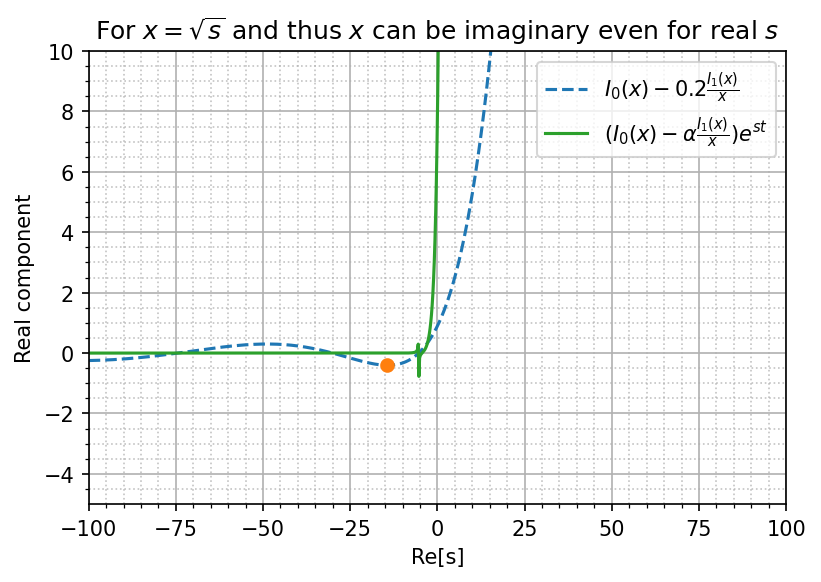

In [ ]:
#@title Plot bessel functions (Cohen numerator) on real input
use_rt = True  #@param {type:"boolean"}
# 1 for real comp, 1j or -1 for imag comp, anything else for mag
plot_y_comp =  1 #@param [0,1,-1,"1j","np.inf", "np.pi", 10] {type:"raw"}
#scale_logp = False #@param {type:"boolean"}
alpha = 0.203713 #@param {type:"slider", min:0, max:1, step:0.1}
imaginary_comp = 5.4  #@param {type:"slider", min:-10, max:10, step:0.1}
t_pt_val = 1

 

if use_rt:
    s=np.linspace(start=-100, stop=100, num=1000, endpoint=True)+0j
else:
    s=np.linspace(start=-10, stop=10, num=1000, endpoint=True)+0j


fig = plt.figure()
fig.set_dpi(150)

if use_rt:
    plt.title(r"For $x=\sqrt{s}$ and thus $x$ can be imaginary even for real $s$")
else:
    plt.title(r"For $x=s$")

if use_rt:
    x = np.sqrt(s+0j)
else:
    x = s + 0j
#plt.plot(s, ychange(x), label=r"$x$")
#for v in [0,]:
#    plt.plot(s, ychange(Iv(x,v=v)), label=f"$I_{v}(x)$")
#plt.plot(s, ychange(I1(x)/x), label=r"$\frac{I_1(x)}{x}$")
#plt.plot(s, ychange(I0(x)-I1(x)),"--", label=r"$I_{0}(x)-I_{1}(x)$")
#plt.plot(s, ychange(I0(x)-I1(x)/x),"--", label=r"$I_{0}(x)-\frac{I_1(x)}{x}$")
yuneven_denom = I0(x)-alpha*I1(x)/x
denom_label = f"I_0(x)-{alpha:.1f}"+r"\frac{I_1(x)}{x}"
plt.plot(s, ychange(yuneven_denom),"--", label=f"${denom_label}$")
argminind = np.argmin(yuneven_denom)
print(f"At s={s[argminind]:.3f}, output was {np.real_if_close(yuneven_denom[argminind]):.3f} which plotted as {ychange(yuneven_denom[argminind]):.3f}" )
plt.plot(s[argminind], ychange(yuneven_denom[argminind]),"o")

#plt.plot(s, ychange(yuneven_numer/yuneven_denom * np.exp(s*t_pt_val)), label=r"$(I_0(x)-\alpha\frac{I_1(x)}{x})e^{st}$")


plt.xlabel("Re[s]")

plt.legend()
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.xlim([np.min(s),np.max(s)])
if False:  #scale_logp: #np.median(np.abs((ychange(x)-x)/x)) > 0.1
    plt.ylabel("$ln(1+|y|)$, " + ychange(0, return_name=True))
    #plt.ylabel("$ln(1+|y|)$, " + ("Imag" if plot_y_comp in [1j,-1,-1j] else "Real") + " component" )
    plt.ylim([-5,10])
else:
    #plt.ylabel(("Imag" if plot_y_comp in [1j,-1,-1j] else "Real") + " component" )
    plt.ylabel(ychange(0, return_name=True))
    #plt.ylim([-500,1000])
    plt.ylim([-5,10])

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipyker

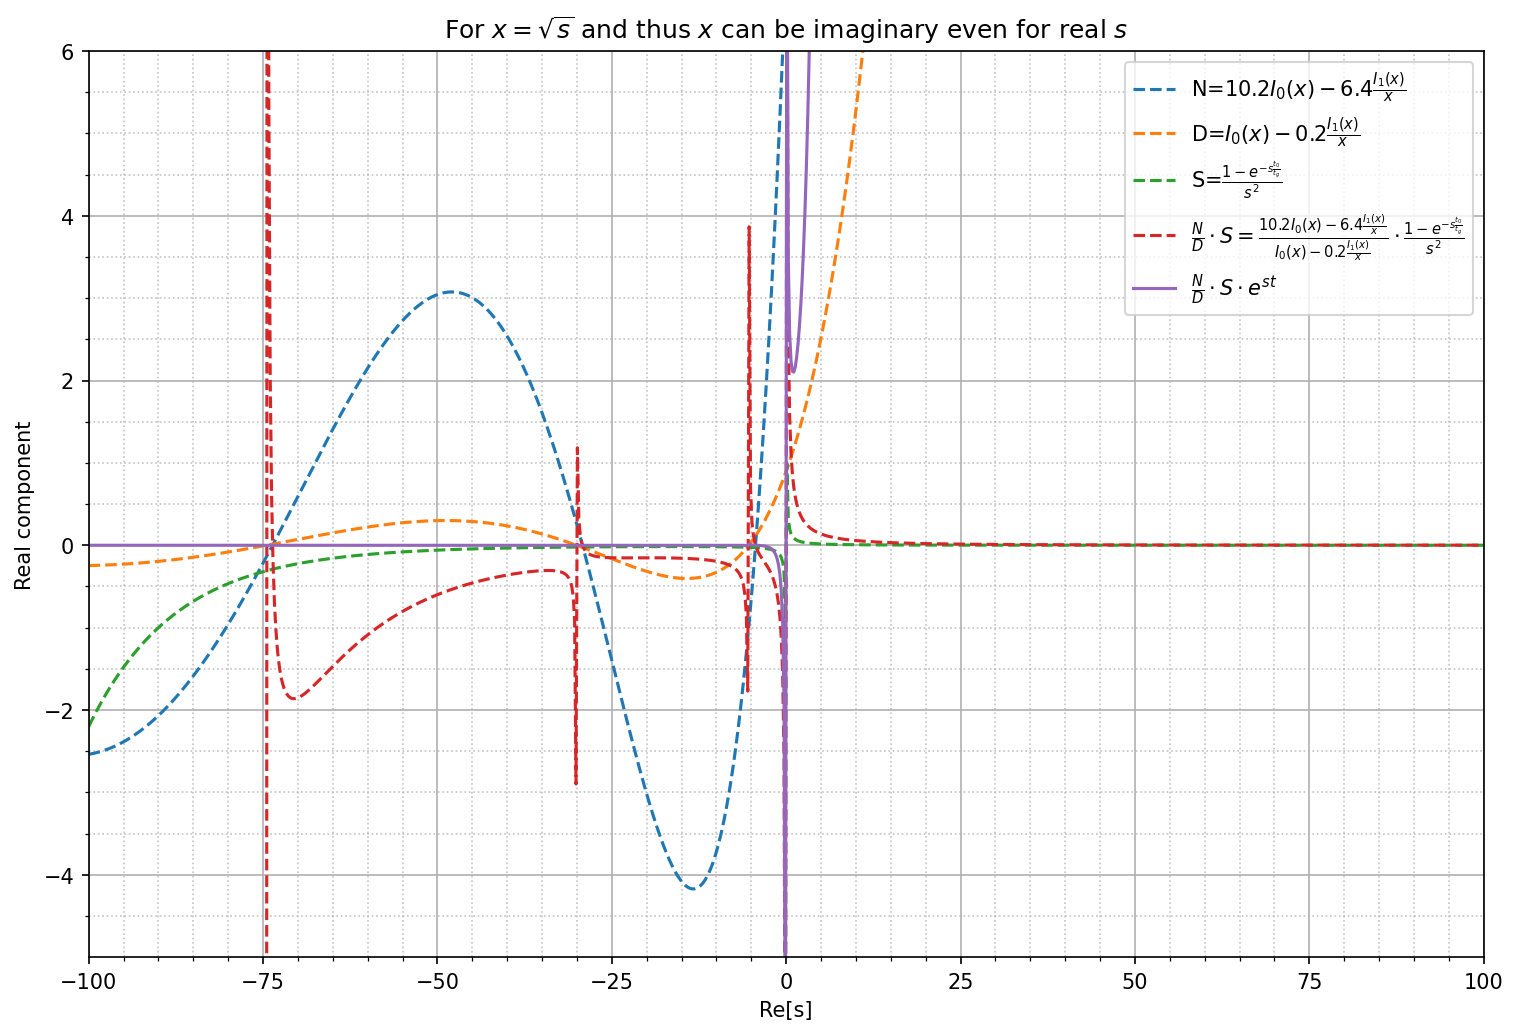

In [ ]:
#@title Cohen components plot on real input
use_rt = True  #@param {type:"boolean"}
# 1 for real comp, 1j or -1 for imag comp, anything else for mag
plot_y_comp =  1 #@param [0,1,-1,"1j","np.inf", "np.pi", 10] {type:"raw"}
#scale_logp = False #@param {type:"boolean"}
alpha = 0.203713 #@param {type:"slider", min:0, max:1, step:0.1}
imaginary_comp = 5.4  #@param {type:"slider", min:-10, max:10, step:0.1}
t_pt_val = 1

C0=0.203713  # alpha
C1=10.207851
C2=31.232221
t0_tg=0.1


if use_rt:
    s=np.linspace(start=-100, stop=100, num=1000, endpoint=True)+0j
else:
    s=np.linspace(start=-10, stop=10, num=1000, endpoint=True)+0j


fig = plt.figure(figsize=(12,8))
fig.set_dpi(150)

if use_rt:
    plt.title(r"For $x=\sqrt{s}$ and thus $x$ can be imaginary even for real $s$")
else:
    plt.title(r"For $x=s$")

if use_rt:
    x = np.sqrt(s+0j)
else:
    x = s + 0j
#plt.plot(s, ychange(x), label=r"$x$")
#for v in [0,]:
#    plt.plot(s, ychange(Iv(x,v=v)), label=f"$I_{v}(x)$")
#plt.plot(s, ychange(I1(x)/x), label=r"$\frac{I_1(x)}{x}$")
#plt.plot(s, ychange(I0(x)-I1(x)),"--", label=r"$I_{0}(x)-I_{1}(x)$")
#plt.plot(s, ychange(I0(x)-I1(x)/x),"--", label=r"$I_{0}(x)-\frac{I_1(x)}{x}$")

yuneven_numer = C1*I0(x)-C0*C2*I1(x)/x
yuneven_denom = I0(x)-alpha*I1(x)/x
numer_label = f"{C1:.1f}I_0(x)-{C0*C2:.1f}"+r"\frac{I_1(x)}{x}"
denom_label = f"I_0(x)-{alpha:.1f}"+r"\frac{I_1(x)}{x}"
strain_s=(1-np.exp(-t0_tg*s))/(s*s)
strain_s_label = r"\frac{1-e^{-s\frac{t_0}{t_g}}}{s^2}"
plt.plot(s, ychange(yuneven_numer),"--", label=f"N=${numer_label}$")
plt.plot(s, ychange(yuneven_denom),"--", label=f"D=${denom_label}$")

plt.plot(s, ychange(strain_s),"--", label=f"S=${strain_s_label}$")
plt.plot(s, ychange(yuneven_numer/yuneven_denom*strain_s),"--", label=r"$\frac{N}{D}\cdot S=\frac{"+numer_label+r"}{"+denom_label+r"}\cdot"+strain_s_label+"$")

plt.plot(s, ychange(yuneven_numer/yuneven_denom*strain_s * np.exp(s*t_pt_val)), label=r"$\frac{N}{D}\cdot S \cdot e^{st}$")


plt.xlabel("Re[s]")

plt.legend()
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.xlim([np.min(s),np.max(s)])
if False:  #scale_logp: #np.median(np.abs((ychange(x)-x)/x)) > 0.1
    plt.ylabel("$ln(1+|y|)$, " + ychange(0, return_name=True))
    #plt.ylabel("$ln(1+|y|)$, " + ("Imag" if plot_y_comp in [1j,-1,-1j] else "Real") + " component" )
    plt.ylim([-5,6])
else:
    #plt.ylabel(("Imag" if plot_y_comp in [1j,-1,-1j] else "Real") + " component" )
    plt.ylabel(ychange(0, return_name=True))
    #plt.ylim([-500,1000])
    plt.ylim([-5,6])



# Imaginary input plots

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


0.731245795100594


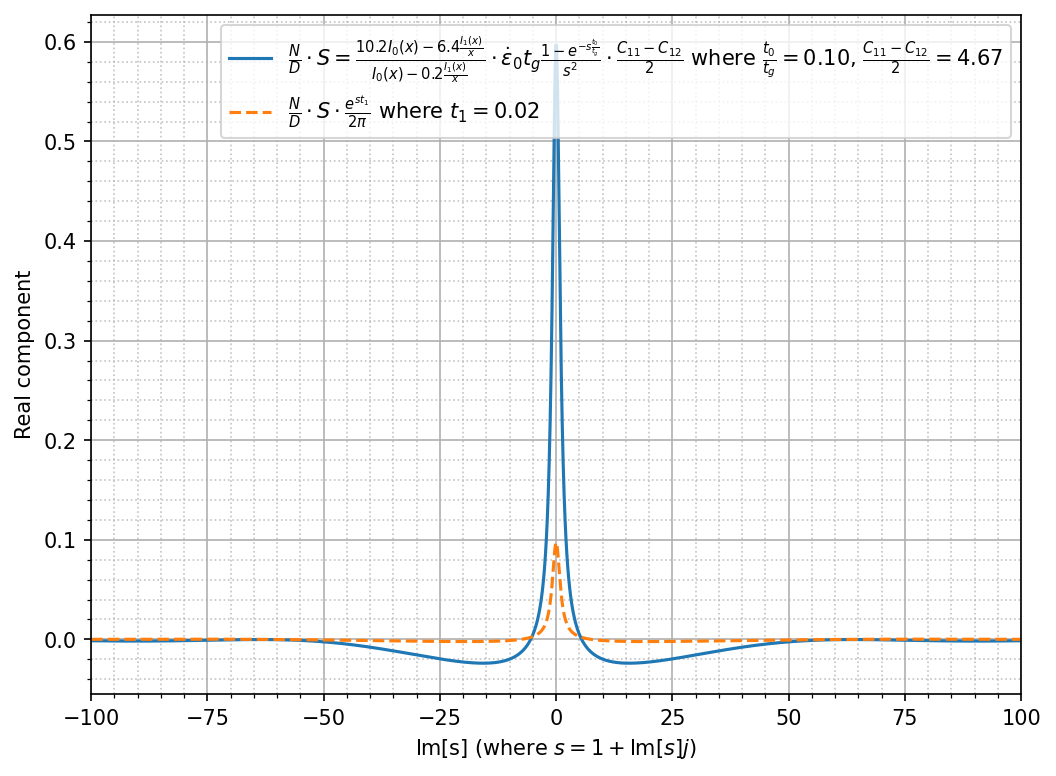

In [24]:
#@title Cohen components plot on imaginary input

use_rt = True  #@param {type:"boolean"}
# 1 for real comp, 1j or -1 for imag comp, anything else for mag
plot_y_comp =  1 #@param [0,1,-1,"1j","np.inf", "np.pi", 10] {type:"raw"}
#scale_logp = False #@param {type:"boolean"}
alpha = 0.203713 #@param {type:"slider", min:0, max:1, step:0.1}
imaginary_comp = 5.4  #@param {type:"slider", min:-10, max:10, step:0.1}
t_pt_val = 0.02  #@param {type:"slider", min:-10, max:10, step:0.1}
t1 = np.array([t_pt_val])
#t1 = np.array([.05, 0.246184, 0.5])


s_real = 1 #@param {type:"slider", min:-10, max:10, step:0.1}

C11 = 5.494505
C12 = 1.648352
C0=0.203713  # alpha
C1=10.207851
C2=31.232221
t0_tg=0.1
tg=40.62
strain_rate = 0.01 

if use_rt:
    s=s_real+1j*np.linspace(start=-100, stop=100, num=1000, endpoint=True)
    x = np.sqrt(s+0j)
else:
    s=s_real+1j*np.linspace(start=-10, stop=10, num=1000, endpoint=True)
    x = s + 0j


yuneven_numer = C1*I0(x)-C0*C2*I1(x)/x
yuneven_denom = I0(x)-alpha*I1(x)/x
numer_label = f"{C1:.1f}I_0(x)-{C0*C2:.1f}"+r"\frac{I_1(x)}{x}"
denom_label = f"I_0(x)-{alpha:.1f}"+r"\frac{I_1(x)}{x}"
strain_s=strain_rate * tg*(1-np.exp(-t0_tg*s))/(s*s)*(C11-C12)/2
strain_s_label = r"\dot{\epsilon}_0 t_g \frac{1-e^{-s\frac{t_0}{t_g}}}{s^2} \cdot \frac{C_{11}-C_{12}}{2}$ where $\frac{t_0}{t_g}=" \
                 + f"{t0_tg:.2f}$, $" + r"\frac{C_{11}-C_{12}}{2}="  \
                 + f"{(C11-C12/2):.2f}"  # don't end with $, that is added later

SN_D = yuneven_numer/yuneven_denom*strain_s

fig = plt.figure(figsize=(8,6))
fig.set_dpi(150)

#plt.plot(np.imag(s), ychange(yuneven_numer),"-", label=f"N=${numer_label}$")
#plt.plot(np.imag(s), ychange(yuneven_denom),"-", label=f"D=${denom_label}$")
#plt.plot(np.imag(s), ychange(strain_s),"-", label=f"S=${strain_s_label}$")
plt.plot(np.imag(s), ychange(SN_D),"-", 
         label=r"$\frac{N}{D}\cdot S=\frac{"+numer_label+r"}{"+denom_label+r"}\cdot"+strain_s_label+"$")


for t1_val in t1:
    #plt.plot(np.imag(s), ychange(SN_D * np.exp(s*t1_val)), 
    #         label=r"$\frac{N}{D}\cdot S \cdot e^{st_1}$ where $"+f"t_1={t1_val:.2f}$")
    inverse_laplace_applied = SN_D * np.exp(s*t1_val)/(2*np.pi)
    plt.plot(np.imag(s), ychange( inverse_laplace_applied ), "--", 
            label=r"$\frac{N}{D}\cdot S \cdot \frac{e^{st_1}}{2\pi}$ where $"+f"t_1={t1_val:.2f}$")


plt.xlabel(r"$\mathrm{Im\left[s\right]}$ (where $s="+f"{s_real}"+r"+\mathrm{Im}\left[s\right]j$)")

plt.legend()
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.xlim([np.min(np.imag(s)),np.max(np.imag(s))])
#plt.ylim([np.min(SN_D)*1.5, np.max(SN_D)*1.5])
if False:  #scale_logp: #np.median(np.abs((ychange(x)-x)/x)) > 0.1
    plt.ylabel("$ln(1+|y|)$, " + ychange(0, return_name=True))
    #plt.ylabel("$ln(1+|y|)$, " + ("Imag" if plot_y_comp in [1j,-1,-1j] else "Real") + " component" )
    plt.ylim([-5,6])
else:
    #plt.ylabel(("Imag" if plot_y_comp in [1j,-1,-1j] else "Real") + " component" )
    plt.ylabel(ychange(0, return_name=True))
    #plt.ylim([-500,1000])
    #plt.ylim([-0.5,0.5])


print(np.real_if_close(np.sum(inverse_laplace_applied)))



## Expanding the exponential term
$s=\left(\Re\left[s\right]+i\Im\left[s\right] \right)=a+bi$  
Recall $\sqrt{i}=\frac{1+i}{\sqrt{2}}$ and  $1/i=-i$

\begin{align}
\operatorname{e}^{st_1}
 &= \operatorname{e}^{\left(a+bi\right)t_1}
 = \operatorname{e}^{at_1}\cdot\operatorname{e}^{bi \cdot t_1}
 = \operatorname{e}^{at_1} \left( \cos{bt_1} + i\sin{bt_1}  \right) \\
 &= \color{red}{\operatorname{e}^{at_1} \cos{bt_1}} + i \color{blue}{\operatorname{e}^{at_1} \sin{bt_1}} \\
 &= \color{red}{\operatorname{e}^{t_1\Re[s]} \cos{\left(t_1\Im[s]\right)}} + i \color{blue}{\operatorname{e}^{t_1\Re[s]} \sin{\left(t_1\Im[s]\right)}}
\end{align}

\begin{align}
&\Re\left[\operatorname{e}^{st_1}\right]=\color{red}{\operatorname{e}^{at_1} \cos{bt_1}},
&\Im\left[\operatorname{e}^{st_1}\right]=\color{blue}{\operatorname{e}^{at_1} \sin{bt_1}}
\end{align}

\\
\\
\begin{align}
\frac{\operatorname{e}^{st_1}}{2\pi i}
 &= \frac{\operatorname{e}^{at_1}}{2\pi} \left( -i\cos{bt_1} + \sin{bt_1} \right) \\
 &= \color{red}{\frac{\operatorname{e}^{at_1}}{2\pi} \sin{bt_1}}+i\color{blue}{\left(-\frac{\operatorname{e}^{at_1}}{2\pi} \cos{bt_1} \right)} \\
 &= \color{red}{\frac{\operatorname{e}^{t_1\Re[s]}}{2\pi} \sin{\left( t_1 \Im[s] \right)}}+i\color{blue}{\left(-\frac{\operatorname{e}^{t_1\Re[s]}}{2\pi} \cos{\left( t_1 \Im[s] \right)} \right) }
 \end{align}

\begin{align}
&\Re\left[\frac{\operatorname{e}^{st_1}}{2\pi i}\right]=\color{red}{\frac{\operatorname{e}^{t_1\Re[s]}}{2\pi} \sin{\left( t_1 \Im[s] \right)}}, 
&\Im\left[\frac{\operatorname{e}^{st_1}}{2\pi i}\right]=\color{blue}{-\frac{\operatorname{e}^{t_1\Re[s]}}{2\pi} \cos{\left( t_1 \Im[s] \right)}}
\end{align}

\\ 
\\ 





\begin{align} 
\frac{1-\exp{\left(-s\frac{t_0}{t_g}\right)}}{s^2}
&=\frac{1-\exp{\left(-\frac{t_0}{t_g}s\right)}}{a^2+b^2} 
= \frac{1-\left( \operatorname{e}^{-\frac{t_0}{t_g}a} \cos{\left(-\frac{t_0}{t_g}b\right)} + i \operatorname{e}^{-\frac{t_0}{t_g}a} \sin{\left(-\frac{t_0}{t_g}b\right)} \right)}{a^2+b^2} \\
&= \frac{1- \operatorname{e}^{-\frac{t_0}{t_g}a} \cos{\left(-\frac{t_0}{t_g}b\right)} + i \left( -\operatorname{e}^{-\frac{t_0}{t_g}a} \sin{\left(-\frac{t_0}{t_g}b\right)} \right) }{a^2+b^2} \\
&= \color{red}{\frac{1- \operatorname{e}^{-\frac{t_0}{t_g}a}}{a^2+b^2} \cos{\left(-\frac{t_0}{t_g}b\right)}}  + i \color{blue}{\frac{ -\operatorname{e}^{-\frac{t_0}{t_g}a}}{a^2+b^2} \sin{\left(-\frac{t_0}{t_g}b\right)}}   \\
&= \color{red}{\frac{1- \operatorname{e}^{-\frac{t_0}{t_g}\Re[s]}}{\Re[s]^2+\Im[s]^2} \cos{\left(-\frac{t_0}{t_g}\Im[s]\right)}}  + i \color{blue}{\frac{ -\operatorname{e}^{-\frac{t_0}{t_g}\Re[s]}}{\Re[s]^2+\Im[s]^2} \sin{\left(-\frac{t_0}{t_g}\Im[s]\right)}}   \\
\end{align}


## Inverse Laplace Equations in Latex
$$f(t=\frac{t_0}{t_g})=\frac{1}{2\pi i} \int_{c-i \infty}^{c+i \infty} F(s)\mathrm{e}^{s\frac{t_0}{t_g}} \mathrm{d}s$$  

$$F(s)= \dot{\epsilon}_0 t_g \left( \frac{C_{11}-C_{12}}{2}\right) \left(  \frac{ 1-\mathrm{e}^{-s\frac{t_0}{t_g}} }{s^2} \right) \left( \frac{ C_1 I_0(\sqrt{s})-C_2 C_0 \frac{I_1(\sqrt{s}) }{\sqrt{s}} }{ I_0(\sqrt{s})-C_0\frac{I_1(\sqrt{s})}{\sqrt{s}} } \right) $$



\begin{align}
s&=a+bi=\Re{[s]}+i\Im{[s]} \\
\mathrm{d}s&=\mathrm{d}a+i \mathrm{d}b = \mathrm{d}a + i \mathrm{d}\Im{[s]}
\end{align}

\\
\begin{align}
f(t=\frac{t_0}{t_g})&=\frac{1}{2\pi i} \int_{a-i \infty}^{a+i \infty} F(s)\mathrm{e}^{s\frac{t_0}{t_g}} \mathrm{d}s \\
&=\int_{a-i \infty}^{a+i \infty} F(s)\frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \mathrm{d}s \\
&=\int_{a-i \infty}^{a+i \infty} \left(\Re{\left[F(s)\right]}+i\Im{\left[F(s)\right]}\right) \left(\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} + i\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \right) \mathrm{d}i\Im{[s]}  \\
&=\int_{a-i \infty}^{a+i \infty} \left(\Re{\left[F(s)\right]}+i\Im{\left[F(s)\right]}\right) \left(\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} + i\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \right) \!i \; \mathrm{d}\Im{[s]}  \\
&=\int_{a-i \infty}^{a+i \infty}\left(
    \Re{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}
    +i\Re{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} 
    +i\Im{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \\
    +i^2\Im{\left[F(s)\right]}\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}
    \right) \!i \; \mathrm{d}\Im{[s]} \\
&=\int_{s=a-i \infty}^{s=a+i \infty}
    i^2 \left( 
        \Re{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}
        +\Im{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} 
    \right) \\
    &+i \left( 
        \Re{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}
        +i^2\Im{\left[F(s)\right]}\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} 
    \right)
    \; \mathrm{d}\Im{[s]} \\
&=\int_{s=a-i \infty}^{s=a+i \infty}
    -\Re{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}
    -\Im{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \\
    &+i \left( 
        \Re{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}
        -\Im{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} 
    \right)
    \; \mathrm{d}\Im{[s]} \\
&=\color{red}{\int_{s=a-i \infty}^{s=a+i \infty} -\Re{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}-\Im{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}  \mathrm{d}\Im{[s]}}\\ 
&+i \color{blue}{\int_{s=a-i \infty}^{s=a+i \infty} \Re{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} -\Im{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \mathrm{d}\Im{[s]}} \\
\end{align}


# Simplify

\begin{align}
&\Re\left[\frac{\operatorname{e}^{st_1}}{2\pi i}\right]=\color{red}{\frac{\operatorname{e}^{t_1\Re[s]}}{2\pi} \sin{\left( t_1 \Im[s] \right)}}, 
&\Im\left[\frac{\operatorname{e}^{st_1}}{2\pi i}\right]=\color{blue}{-\frac{\operatorname{e}^{t_1\Re[s]}}{2\pi} \cos{\left( t_1 \Im[s] \right)}}
\end{align}
\\

\begin{align}
\Re{\left[f(t=\frac{t_0}{t_g})\right]}&=\color{red}{\int_{s=a-i \infty}^{s=a+i \infty} -\Re{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \quad -\Im{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \quad \mathrm{d}\Im{[s]}}
\\ 
&=\color{red}{\int_{s=a-i \infty}^{s=a+i \infty} -\Re{\left[F(s)\right]}\cdot -\frac{\operatorname{e}^{t_0/t_g\Re[s]}}{2\pi} \cos{\left( t_0/t_g \Im[s] \right)} \quad -\Im{\left[F(s)\right]}\cdot \frac{\operatorname{e}^{t_0/t_g\Re[s]}}{2\pi} \sin{\left( t_0/t_g \Im[s] \right)} \quad  \mathrm{d}\Im{[s]}}\\
&=\color{red}{\int_{s=a-i \infty}^{s=a+i \infty} \Re{\left[F(s)\right]} \frac{\operatorname{e}^{at_0/t_g}}{2\pi} \cos{\left( t_0/t_g \Im[s] \right)} \quad -\Im{\left[F(s)\right]} \frac{\operatorname{e}^{a t_0/t_g}}{2\pi} \sin{\left( t_0/t_g \Im[s] \right)} \quad  \mathrm{d}\Im{[s]}}\\ 
&=\color{red}{\int_{b=-\infty}^{b=\infty} \Re{\left[F(a+bi)\right]} \frac{\operatorname{e}^{at_0/t_g}}{2\pi} \cos{\left( t_0/t_g b \right)} \quad -\Im{\left[F(a+bi)\right]} \frac{\operatorname{e}^{a t_0/t_g}}{2\pi} \sin{\left( t_0/t_g b \right)} \quad  \mathrm{d} b}\\ 
&= \frac{\operatorname{e}^{a\frac{t_0}{t_g}}}{2\pi} \int_{-\infty}^{\infty} \Re{\left[F(a+bi)\right]}  \cos{\left(\frac{t_0}{t_g} b \right)} \quad -\Im{\left[F(a+bi)\right]}  \sin{\left( \frac{t_0}{t_g} b \right)} \quad  \mathrm{d} b\\ 
\\
\\
\Im{\left[f(t=\frac{t_0}{t_g})\right]}&= \color{blue}{\int_{s=a-i \infty}^{s=a+i \infty} \quad \Re{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \quad -\Im{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \quad \mathrm{d}\Im{[s]}} \\
&= \frac{\operatorname{e}^{a\frac{t_0}{t_g}}}{2\pi} \int_{-\infty}^{\infty} \Re{\left[F(a+bi)\right]} \sin{\left(\frac{t_0}{t_g} b \right)} \quad + \Im{\left[F(a+bi)\right]}  \cos{\left( \frac{t_0}{t_g} b \right)} \quad  \mathrm{d} b\\ 
\end{align}



\\
\\
\begin{align}
\Re{\left[f(t=\frac{t_0}{t_g})\right]}&=&\int_{s=a-i \infty}^{s=a+i \infty} &-\Re{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}&-\Im{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}  &\mathrm{d}\Im{[s]}\\ 
\Re{\left[f(t=\frac{t_0}{t_g})\right]}&=&\int_{s=a-i \infty}^{s=a+i \infty} &-\Re{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}&-\Im{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} & \mathrm{d}\Im{[s]}\\ 
\end{align}

In [16]:
print( np.mean(laplace_val) )

<IPython.core.display.Javascript object>

(0.0037974042307536834+1.1102230246251566e-18j)


<IPython.core.display.Javascript object>

[-0.00099973-0.00068895j -0.0010026 -0.00069622j -0.00100549-0.00070349j
 ... -0.00100549+0.00070349j -0.0010026 +0.00069622j
 -0.00099973+0.00068895j]


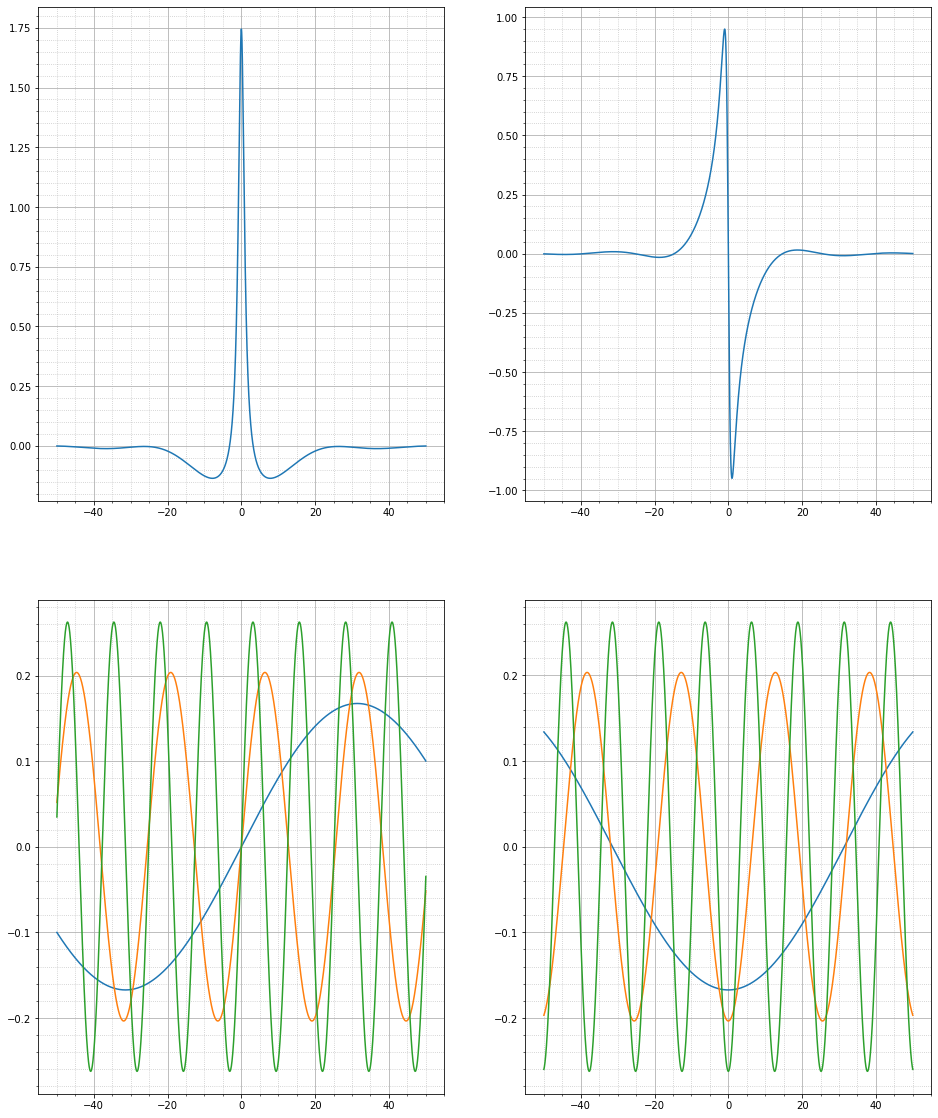

In [17]:
s_real = 1 #@param {type:"slider", min:-10, max:10, step:0.1}
(s, ds)=np.linspace(start=s_real-50j, stop=s_real+50j, num=10000, endpoint=True, retstep=True)
t1 = np.array([.05, 0.246184, 0.5])

VPEs = [
        (CohenModel(), fr"$Cohen$"), 
        #(getCohenModelModified(E1=3.5), fr"$Cohen, E_1=3.5$") 
        ]

# The [...,None] index allows t1 to be either a single value (returns single value) or a matrix (returns matrix)
laplace_val = VPEs[0][0].laplace_value(s, dimensional=True)
expon_2pii = np.exp(s[...,None]*t1)/(2j*np.pi)
ys = [
        laplace_val, 
        expon_2pii
        ]
ys2 = [[y.real, y.imag] for y in ys]
#ys.append(ys[0].real* )

#fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,20))
fig = plt.figure(constrained_layout=True)

gs0 = fig10.add_gridspec(1, 3)
gs0[0].add_gridspec

for ind, y in enumerate(ys):
    axs[ind,0].plot(np.imag(s), np.real(y))
    axs[ind,1].plot(np.imag(s), np.imag(y))

for ax in axs.flat:
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

print(laplace_val)

<IPython.core.display.Javascript object>

t1=[0.05     0.246184 0.5     ]
[0.4513582  2.08284462 1.96016606]
[-1.49679192e-17  1.56733706e-16 -7.08204247e-18]  j



,t/tg,f(t),PercentError0,PercentError1,LastPlotted
CohenModel - t1=0.05,0.050000,0.660289,-31.6,-31.6,0.451358
CohenModel - t1=0.25,0.246184,2.695266,-22.7,-22.7,2.082845
CohenModel - t1=0.50,0.500000,2.094081,-6.4,-6.4,1.960166


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/inverting.py:153: RuntimeWarning: divide by zero encountered in true_divide
  F_s_val, is_inf = F_s(beta_mesh / t_mesh, return_error_inds=True)
/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/inverting.py:153: RuntimeWarning: invalid value encountered in true_divide
  F_s_val, is_inf = F_s(beta_mesh / t_mesh, return_error_inds=True)
/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-S

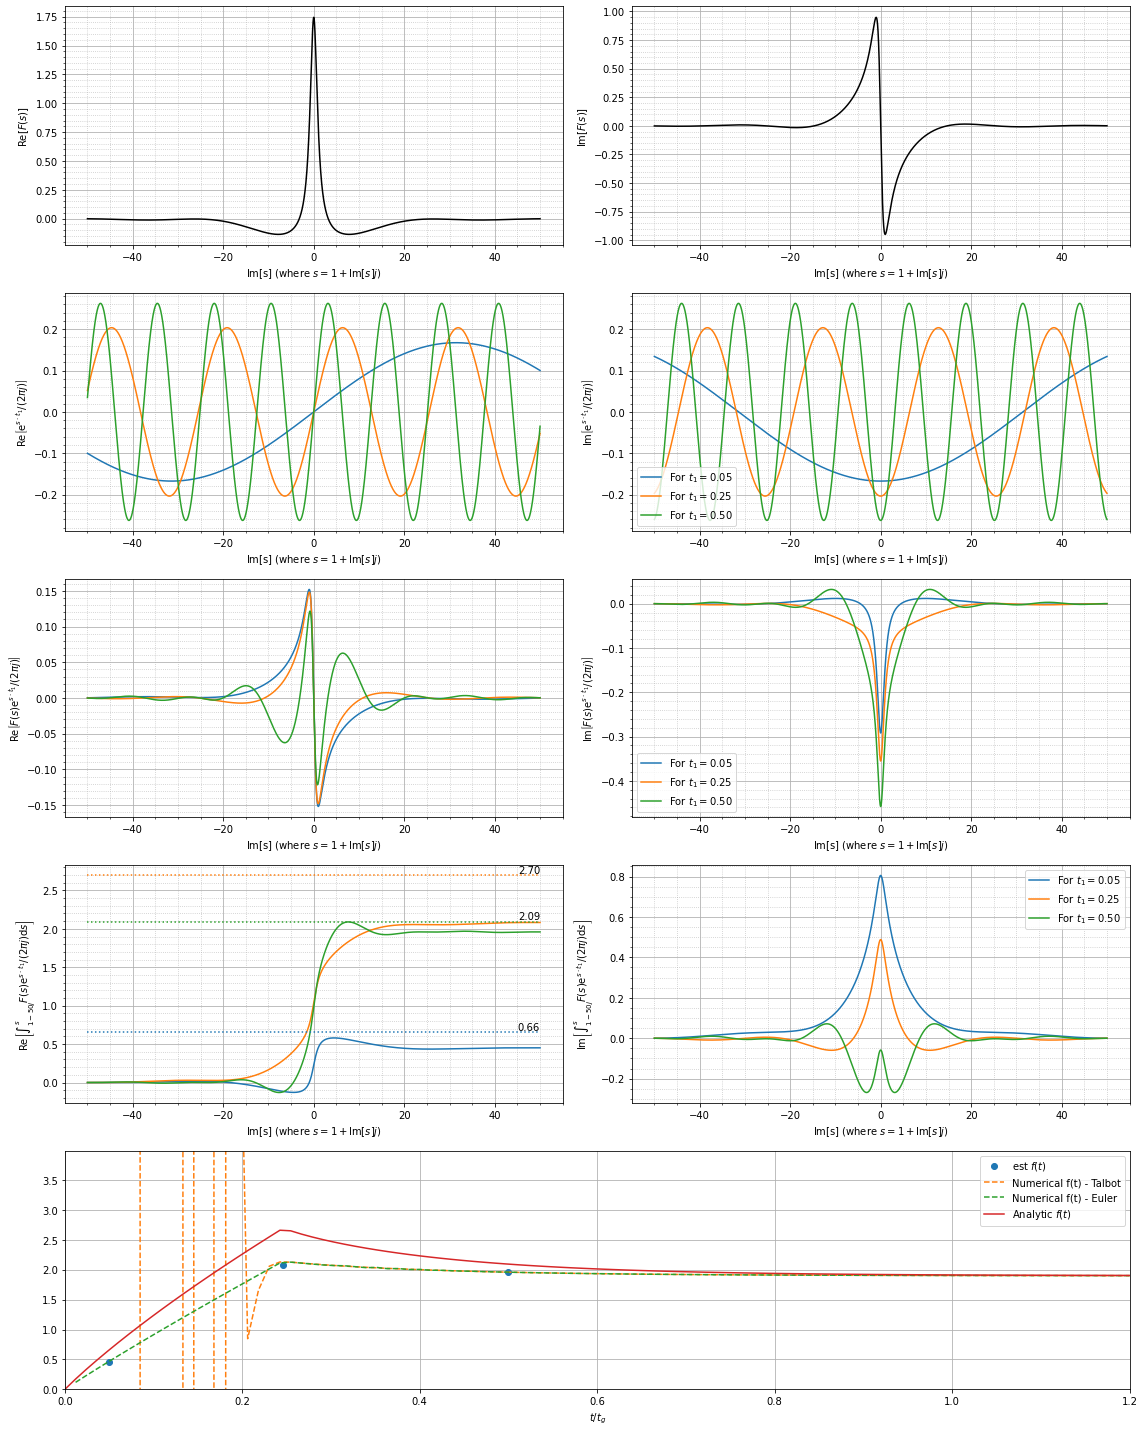

In [15]:
#@title Steps of inverse laplace of Cohen

importlib.reload(viscoporoelastic_model)
importlib.reload(inverting)

from viscoporoelastic_model import CohenModel, getCohenModelModified

VPEs = [
        (CohenModel(), fr"$Cohen$"), 
        #(getCohenModelModified(E1=3.5), fr"$Cohen, E_1=3.5$") 
        ]
do_plot = True  #@param {type: "boolean"}
s_real = 1 #@param {type:"slider", min:-10, max:10, step:0.1}
(s, ds)=np.linspace(start=s_real-50j, stop=s_real+50j, num=10000, endpoint=True, retstep=True)
#t1 = np.array([.01,.1, 1.5])  # nondimensional
#t1 = np.array([.01,.1, 1.0])  # nondimensional
t1 = np.array([.05, 0.246184, 0.5])
#t1 = np.concatenate( (np.arange(0.01,0.1,0.01), np.arange(.1,2,.1)) )  # nondimensional



t0_tg = VPEs[0][0].t0_tg
tg = VPEs[0][0].tg


func = [vpe.laplace_value for vpe, label in VPEs]
inv_funcs_anal = [vpe.inverted_value for vpe, label in VPEs]


plot_s = np.imag(s[...,None])
yss = []
row_namess = []

for ind, (vpe, label) in enumerate(VPEs):
    # The [...,None] index allows t1 to be either a single value (returns single value) or a matrix (returns matrix)
    ys = [
          vpe.laplace_value(s, dimensional=True), 
          np.exp(s[...,None]*t1)/(2j*np.pi)
          ]
    ys.append( (ys[0].T*ys[1].T).T )
    ys.append( np.cumsum(ys[-1], axis=0)*ds )
    # No dollar signs ($) here - added later
    row_names = [r"F(s)", 
                 r"\mathrm{e}^{s \cdot t_1}/(2 \pi j)"
                 #"\frac{exp(s \cdot t1)}{2j\cdot \pi}"
                 ]
    row_names.append( row_names[0]+row_names[1] )
    row_names.append( r"\int_{"+f"{np.min(s):.0f}" +r"}^{s}" + row_names[-1] + r" \mathrm{d}s")
    #row_names.append( r"\int_{-\infty}^{s}" + row_names[-1] + " ds")
    yss.append(ys)
    row_namess.append(row_names)

    print(f"t1={t1}")
    print(np.sum(np.real(ds*ys[2]), axis=0))
    print(np.sum(np.imag(ds*ys[2]), axis=0), " j" )
    #print( *zip(t1, np.real_if_close(np.sum(ds*ys[2], axis=0) ) )  )
    print()
    

    integrand_vals = ds*ys[2]
    inv_laplace_integ = np.sum(ds*ys[2], axis=0)
    inv_laplace_integ_re = np.real_if_close(inv_laplace_integ)
    analytic_values = vpe.inverted_value(t=t1*vpe.tg)

    df_params = pd.DataFrame({
        "t/tg": t1,
        "f(t)": analytic_values,
        **{
        #f"L-1[F(s)]_using_sum{ind}": inv_laplace_integ_re,
        #f"RawError{ind}": inv_laplace_integ_re-analytic_values,
        f"PercentError{ind}": np.round((inv_laplace_integ_re-analytic_values)/analytic_values*100, 1)
        for ind, inv_laplace_integ_re in enumerate(
            [
             np.real_if_close(np.sum(ds*ys[2], axis=0) ),
             np.real_if_close(np.trapz(ys[2],dx=ds,axis=0) ),
            ]
            )
        },
        "LastPlotted": np.real_if_close(ys[3][-1,:]),
        #"Re":np.real(inv_laplace_integ),
        #"Im":np.imag(inv_laplace_integ),
        }, 
        index=[f"{vpe.get_model_name()} - t1={t1_val:.2f}" for ind, t1_val in enumerate(t1)]
        )
    display(df_params)
    


if do_plot:
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,20),
                        subplot_kw={
                            #"sharex":"all"
                            })

    for ax in axs.flat[0:-2]:  # Don't do the final two, which will be merged
        ax.grid(which="major")  # set major grid lines
        ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ##ax.set_xlabel("$Im[s]=(s-Re[s])/i$, " + f"Re[s]={s_real}")
        #ax.set_xlabel(r"$\mathrm{Im\left[s\right]}$ ($\mathrm{Re}\left[s\right]="+f"{s_real}$)")
        ax.set_xlabel(r"$\mathrm{Im\left[s\right]}$ (where $s="+f"{s_real}"+r"+\mathrm{Im}\left[s\right]j$)")

    #plt.suptitle(f"$s={s_real}+"+r"\mathrm{Im}\left[s\right]j$")
    #fig.supxlabel(f"Component of complex output")  # requires matplotlib 3.4

    gs = axs.flat[-2].get_gridspec()  #axs[-1,-2].get_gridspec()  #
    # remove the underlying axes
    for ax in axs[-1,:]: #ax in axs.flat[-2:0]:
        ax.remove()
    axbig = fig.add_subplot(gs[-1, -2:])
    axbig.grid(which="major")
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    axbig.plot(t1, ys[3][-1,:],"o", label="est $f(t)$")
    t_plot = np.linspace(0,1.2,num=100,endpoint=True)
    analytic_values_plot = vpe.inverted_value(t=t_plot*vpe.tg)
    axbig.plot(t_plot[int(len(t_plot)/25):], 
                inverting.talbot_inversion(vpe.laplace_value, 
                                            t_plot[int(len(t_plot)/25):]), "--", label="Numerical f(t) - Talbot")
    axbig.plot(t_plot, inverting.euler_inversion(vpe.laplace_value, t_plot), "--", label="Numerical f(t) - Euler")
    axbig.plot(t_plot, analytic_values_plot, "-", label="Analytic $f(t)$")

    axbig.set_xlabel("$t/t_g$")
    axbig.set_xlim([0, np.max(t_plot)])
    axbig.set_ylim([0, np.max(analytic_values_plot)*1.5 ])
    axbig.legend()

    for ys, row_names in zip(yss, row_namess):
        for ind,y in enumerate(ys):
            axs.flat[0+ind*2].plot(plot_s, np.real(y), "k" if y.ndim<=1 else "")
            axs.flat[1+ind*2].plot(plot_s, np.imag(y), "k" if y.ndim<=1 else "")
            axs.flat[0+ind*2].set_ylabel(r"$\mathrm{Re} \left[" +f"{row_names[ind]}"+r"\right]$")
            axs.flat[1+ind*2].set_ylabel(r"$\mathrm{Im} \left[" +f"{row_names[ind]}"+r"\right]$")
            if y.ndim>1:
                axs.flat[1+ind*2].legend([f"For $t_1={t1_val:.2f}$" for t1_val in t1 ])
        
        # put this OUTSIDE the for loop
        #Draw horizontal line where the analytic value should be
        analytic_val = vpe.inverted_value(t=t1*vpe.tg)
        axs.flat[0+ind*2].set_prop_cycle(None)  # Resets the color cycle so colors of lines match the colors of plot
        axs.flat[0+ind*2].plot(
            plot_s[ np.array([0,-1])],
            #np.repeat(plot_s[(-1)][...,None],2), 
            np.repeat(analytic_val[...,None], 2, axis=1).T, ":"
            )
        
        for ind, t1_val in enumerate(t1):
            axs.flat[-4].annotate(
                f"{analytic_val[ind]:0.2f}", (np.max(plot_s), analytic_val[ind]),
                xycoords="data", va='bottom', ha="right")
            

    fig.tight_layout()



# Complex input, but varying only real comp, of bessel functions

<IPython.core.display.Javascript object>

At s=-14.239+0.000j, output was -0.403 which plotted as -0.403
At s=-7.232+0.000j, output was -0.903+0.504j which plotted as -0.903


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will a

(-5.0, 10.0)

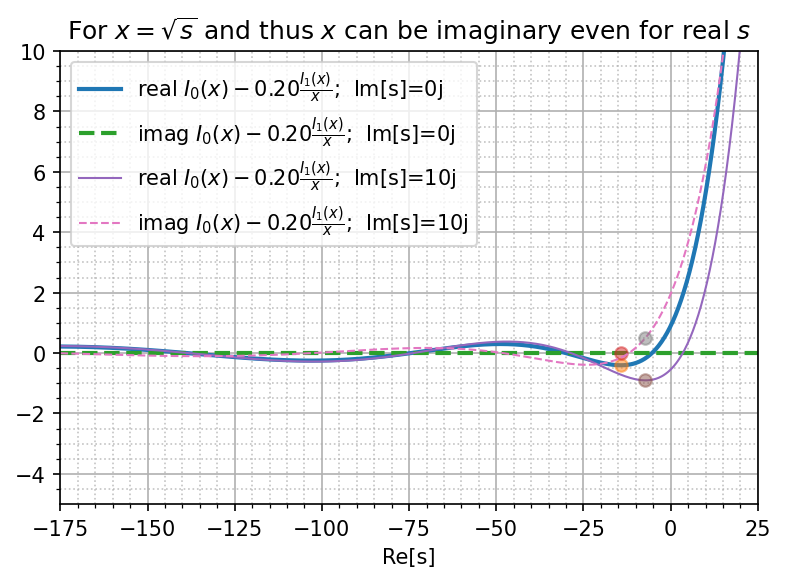

In [ ]:
use_rt = True  #@param {type:"boolean"}
alpha = 0.9 #@param {type:"slider", min:0, max:1, step:0.1}
imaginary_comp = 10  #@param {type:"slider", min:-10, max:10, step:0.1}

def angle_or_nan(x): 
    x = np.real_if_close(x)  # necesssary or alternating between -1e-9j and 1e-9j would give alternating angles for example
    return np.where(np.abs(x)<1e-8, np.nan, np.angle(x)) 
use_abs_polar = False #@param {type:"boolean"}
if use_abs_polar:
    methods_dash = [(np.abs, "-"), (angle_or_nan, "--")]
else:
    methods_dash = [(np.real, "-"), (np.imag, "--")]

if use_rt:
    s=np.linspace(start=-100-75, stop=100-75, num=1000, endpoint=True)+0j
else:
    s=np.linspace(start=-10, stop=10, num=1000, endpoint=True)+0j


fig = plt.figure()
fig.set_dpi(150)

if use_rt:
    plt.title(r"For $x=\sqrt{s}$ and thus $x$ can be imaginary even for real $s$")
else:
    plt.title(r"For $x=s$")

for imag_comp in [0, imaginary_comp]:
    if use_rt:
        x = np.sqrt(s+0j + 1j*imag_comp)
    else:
        x = s + 1j*imag_comp

    yuneven = I0(x)-alpha*I1(x)/x
    argminind = np.argmin(yuneven)
    print(f"At s={s[argminind]:.3f}, output was {np.real_if_close(yuneven[argminind]):.3f} which plotted as {ychange(yuneven[argminind]):.3f}" )
    for method, dash in methods_dash:
        plt.plot(s, method(yuneven),dash, linewidth=(2 if imag_comp==0 else 1), 
                label=f"{method.__name__} $I_0(x)-{alpha:.2f}"+r"\frac{I_1(x)}{x}$;  "+f"Im[s]={imag_comp}j")
        plt.plot(s[argminind], method(yuneven[argminind]),"o",alpha=0.5)


plt.xlabel("Re[s]")

plt.legend()
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.xlim([np.min(s),np.max(s)])

plt.ylim([-5,10])



# Summary
## For $x=s$ on real s axis. 
* So $I_0(x)-\frac{I_1(x)}{x}$ is a concave up paraboloid when you say $x$ is real and it is plotted against $s=x$.    


## However, when you let $x=\sqrt{s}$, then even on the real $s$ axis: 
* The **input, $x$, to the bessel functions** can be (purely) **imaginary** or real
* $I_0(\sqrt{s})$ is still always real  
  * However, it becomes  sinusoidal for $s<0$ .  
  * It monotonically increasing (like an exponential) for $s>0$.
* $I_1(\sqrt{s})$ is purely **imaginary** or real.  
  * Thus $\frac{I_1(\sqrt{s})}{\sqrt{s}}$ is always real
  * Additionally it is monotonically increasing and approaches 0 as $s\to-\infty$
* $I_1(\sqrt{s})-\frac{I_1(\sqrt{s})}{\sqrt{s}}$ is real
* $I_1(\sqrt{s})-\alpha\frac{I_1(\sqrt{s})}{\sqrt{s}}$ is real (tested only for $0≤\alpha≤1$)
* Then the plot of $I_0(\sqrt{s})-\frac{I_1(\sqrt{s})}{\sqrt{s}}$ against $s=x^2$ is sinusoidal (but still real) for $s < 0$ and is monotonically increasing (like a positive exponential graph) for $s > 0$.  
  * There are no zeros for $s≥0$ of $I_0(\sqrt{s})-\alpha\frac{I_1(\sqrt{s})}{\sqrt{s}}$  (tested only for $0≤\alpha≤1$)
  * However there are some (infinite number?) of zeroes for $s < 0$
  * These zeros should be about the same as those for $I_0(\sqrt{s})$ as the $I_1$ term becomes negligible. 
  * Thus $\alpha$ should have negligible effect on the poles

For real (but either + or -) inputs to the bessel functions, there are no zeros for $I_0(x)-\alpha\frac{I_1(x)}{x}$ and for $0<\alpha≤1$. The output is always positive (and real) with a min at $x=0$.

## For $x=s$, then  on the (purely) imaginary $s$ axis: 


## For $x=\sqrt{s}$, then  on the (purely) imaginary $s$ axis: 

* Recall $\sqrt{i}=\frac{1+i}{\sqrt{2}}$
* Therefore, the inputs to the bessel functions will be complex


# Cohen Model plot

<IPython.core.display.Javascript object>

$Cohen$


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModel - Line #1,0.246184,40.62,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221


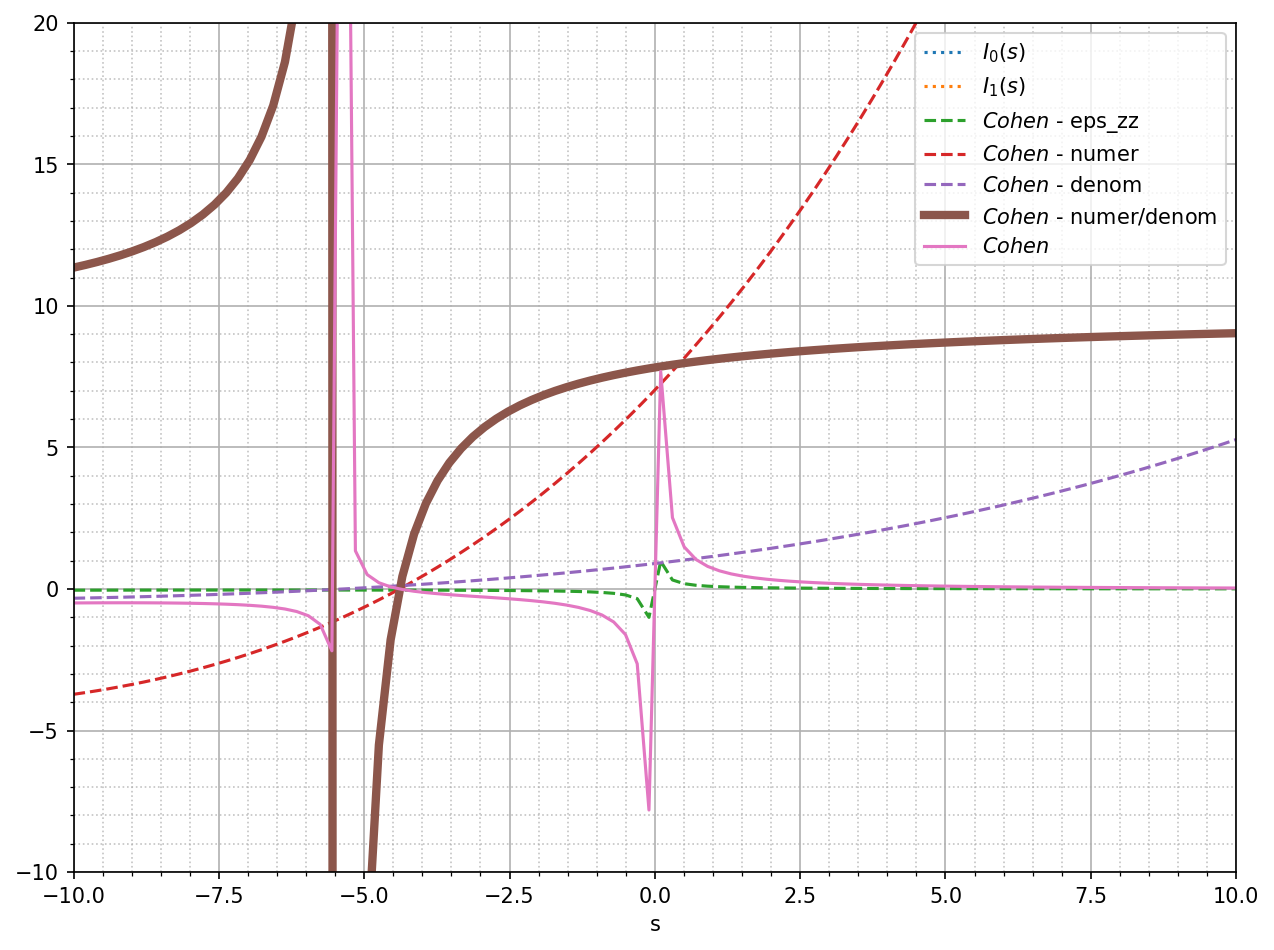

In [ ]:
exp = np.exp
sqrt = np.sqrt

VPEs = [(CohenModel(), fr"$Cohen$"), 
        #(getCohenModelModified(E1=3.5), fr"$Cohen, E_1=3.5$") 
        ]
    

def ychange(vals):
    return vals


s=np.linspace(start=-10, stop=10, num=100, endpoint=True)+0j
fig = plt.figure()
fig.set_figheight(7.5)
fig.set_figwidth(10)
fig.set_dpi(150)
for v in [0,1]:
    # Avoid plotting this by changing s axis (still keeps colors in legend though)
    plt.plot(s*0-100, ychange(Iv(s,v=v)),":", label=f"$I_{v}(s)$")

for vpe, label in VPEs:
    print(label)
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    t0=t0_tg*tg
    delta1, delta2, delta3, C11, C12, C13, C33, C0, C1, C2 = vpe.get_calculable_constants()


    I1rts_s = I1(sqrt(s)) / sqrt(s)
    I0rts = I0(sqrt(s))
    eps_zz = strain_rate * tg * (1 - exp(-t0_tg * s))/ (s*s)
    numer = (C1*I0rts - C2*C0*I1rts_s)  #* (1 - exp(-t0_tg * s)) 
    denom = (I0rts - C0*I1rts_s)        #* s*s
    dimensionalize = (C11-C12)/2
    plt.plot(s,ychange(eps_zz),"--", label=label+": eps_zz")
    plt.plot(s,ychange(numer), "--", label=label+": numer")
    plt.plot(s,ychange(denom), "--", label=label+": denom")
    # ignore *dimensionalize for now
    plt.plot(s,ychange(numer/denom), label=label+" - numer/denom", linewidth=4)
    plt.plot(s,ychange(numer/denom*eps_zz), label=label)
    #plt.plot(s,ychange(vpe.laplace_value(s)), label=label, linewidth=4)

plt.xlabel("s")

plt.legend()
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.xlim([np.min(s),np.max(s)])
plt.ylim([-10,20])
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
#plt.yscale('log')

df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

In [ ]:
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)
times_eval = np.array([1.0,0.8,0.6,0.4,0.3,0.24])
eval_vals = [vpe.inverted_value(times_eval*vpe.tg) for vpe, label in VPEs]
np.vstack([times_eval, eval_val])
df_eval = pd.DataFrame(np.vstack([times_eval, *eval_vals]).transpose(), columns=["t/tg",*[label for vpe, label in VPEs] ])

print()
display(df_eval)


<IPython.core.display.Javascript object>

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModel - Line #1,0.246184,40.62,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified - Line #2,0.246184,40.62,0.01,3.5,19,0.75,0.24,0.228779,0.565365,2.186544,8.649305,6.649305,3.671667,20.762400,0.231232,21.068372,36.889982


,t/tg,$Cohen$,"$Cohen, E_1=3.5$"
0,1.00,1.913299,1.905023
1,0.80,1.938857,1.914503
2,0.60,2.013534,1.941874
3,0.40,2.232027,2.021013
4,0.30,2.473256,2.107653
5,0.24,2.638236,2.135801


# Complex plane input

In [ ]:
#@title Settings for calculations for complex figure

#methods = [ np.real, np.imag, np.abs, np.angle]  # convert complex to float
methods = [ np.real, np.imag, None]  #np.real_if_close]
method_output_formats = ["","j","",""]

#re_parts = np.arange(-3,3 +1)
#im_parts = np.arange(-2,2 +1)

#re_parts, re_step = np.linspace( -12,  12,num=12*2+1,endpoint=True,retstep=True)
#im_parts, im_step = np.linspace(  -8,   8,num= 8*2+1,endpoint=True,retstep=True)
re_parts, re_step = np.linspace( -100,   4,num=104*10+1, endpoint=True,retstep=True)
im_parts, im_step = np.linspace(  -20,  20,num=20*2*10+1,endpoint=True,retstep=True)

alpha = 0.2;

funcs = [ 
         #("I0",I0), 
         #("I1",I1), 
         #("I1/x",  lambda x: I1(x)/x) , 
         #(r"$I_0(x)-\alpha \frac{I_1(x)}{x}$",lambda x: I0(x)-alpha*I1(x)/x), 
         (r"$I_0(\sqrt{x})-\alpha \frac{I_1(\sqrt{x})}{\sqrt{x}}$",lambda x: I0(np.sqrt(x))-alpha*I1(np.sqrt(x))/np.sqrt(x)), 
         ("x", lambda x: x),
         #("e^x", lambda x: np.exp(x)) 
        ]


re_min = np.nanmin(re_parts)
re_max = np.nanmax(re_parts)
im_min = np.nanmin(im_parts)
im_max = np.nanmax(im_parts)
symmetric = [math.isclose(-re_min, re_max), math.isclose(-im_min, im_max)]
print(f"{re_min}->{re_max}, {im_min}j->{im_max}j")


<IPython.core.display.Javascript object>

-100.0->4.0, -20.0j->20.0j


In [ ]:
#@title Perform calculations for complex figure

re_grid, im_grid = np.meshgrid(re_parts, im_parts, sparse=False, indexing='xy')
input_grid = re_grid + im_grid*1j

outputs = [func(input_grid) for (func_name, func) in funcs]
outputs_hsv = [complex_array_to_rgb(output) for output in outputs]
#print( np.real(funcs[2][1](input_grid)) )

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in remainder
  if __name__ == '__main__':


In [ ]:
#@title Settings for complex figure

use_contourf = False
always_use_2D_colors = True
draw_text_spacing_re = 3*5  # should be positive. Make value 1 to draw every block.
draw_text_spacing_im = 3*5  # should be positive. Make value 1 to draw every block.
fig_size = (30, 30)

<IPython.core.display.Javascript object>

In [ ]:
#@title Draw complex figure

#methods = [ np.real, np.imag, None]  #np.real_if_close]
methods = [ None]

fig, axs = plt.subplots(nrows=len(funcs), ncols=len(methods), figsize=fig_size,
                        subplot_kw={
                            #'xticks': np.arange(len(re_parts)),
                            #'xticklabels': ["{:6.1f}".format(i) for i in re_parts ]
                            #'yticks': im_parts,
                            }
                        )



#for ind, (ax, method) in enumerate(zip(axs.flat, itertools.cycle(methods) )):
#    row_num, col_num = divmod(ind, len(methods))
#    output =  funcs[row_num][1](input_grid) 
for row_num, (func_name, func) in enumerate(funcs):
    output =  outputs[row_num]
    for col_num, method in enumerate(methods):
        t0 = time.time()
        ind = row_num*len(methods)+col_num
        #ax = axs[row_num, col_num]
        ax = axs.flat[ind]
        # trfm = transformed (i.e. method has been applied)
        output_trfm = output if method is None else method(output)
        if use_contourf:
            #ax.pcolormesh( re_grid, im_grid, output_trfm )
            ax.contourf( re_grid, im_grid, output_trfm, cmap='RdYlGn' )  #PuOr
        else:
            if always_use_2D_colors or np.any(np.iscomplex(output_trfm)):
                if method is None:
                    output_disp = outputs_hsv[row_num]
                elif method_output_formats[col_num].strip() in ["j","i"]:
                    output_disp = complex_array_to_rgb(output_trfm*1j)
                else:
                    output_disp = complex_array_to_rgb(output_trfm)
                print(f"Using rgb for plot at r={row_num}, c={col_num}")
                cmap_to_use = None
            else:
                output_disp = output_trfm
                print(f"NOT using rgb for plot at r={row_num}, c={col_num}")
                cmap_to_use = 'RdYlGn'

            fig=ax.imshow( output_disp,origin='lower', cmap=cmap_to_use,
                    extent=np.array([re_min-re_step/2,re_max+re_step/2,im_min-im_step/2,im_max+im_step/2]), #[re_min-0.5,re_max+0.5,im_min-0.5,im_max+0.5] #[-3.5,3.5,-2.5,2.5] 
                    vmin=-np.nanmax(np.abs(output_trfm)),
                    vmax=+np.nanmax(np.abs(output_trfm)),
                )    
        print(f"t1={time.time() - t0}")
            
        ax.set_xticks(re_parts-re_step/2, minor=True)
        ax.set_yticks(im_parts-im_step/2, minor=True)
        ax.grid(which="minor", color="lightgray", linestyle='--', linewidth=1)
        #ax.tick_params(which="minor", bottom=False, left=False)


        # Loop over data dimensions and create text annotations.
        for ind1, re_part in enumerate(re_parts):
            for ind2, im_part in enumerate(im_parts):
                # if re_parts has len 7
                # then indices [ 0, 1, 2, 3, 4, 5, 6]
                # becomes      [-3,-2,-1, 0, 1, 2, 3]
                ind1_center = round(ind1-(len(re_parts)-1)/2)
                ind2_center = round(ind2-(len(im_parts)-1)/2)

                # Do this to decrease frequency of text being drawn so it doesn't clutter
                if ind1_center % draw_text_spacing_re == 0 and ind2_center % draw_text_spacing_im == 0:

                    #label = "{:.1f}".format(output_trfm[ind2][ind1])+method_output_formats[col_num]
                    output_val = output_trfm[ind2][ind1]
                    if method_output_formats[col_num].strip() in ["j","i"]:
                        output_val = output_val * 1j
                    #label = "{:2f}\n{:.1f}j".format(np.real(output_val),np.imag(output_val))
                    label = []
                    if not math.isclose(output_val.real,0,abs_tol=1e-12):
                        label += f"{output_val.real:.1f}"  if np.abs(output_val.real)<100  else f"{output_val.real:.1e}"
                    label += "\n"
                    if not math.isclose(output_val.imag,0,abs_tol=1e-12):
                        label += f"{output_val.imag:.1f}j" if np.abs(output_val.imag)<100  else f"{output_val.imag:.1e}"
                    label = "".join(label)

                    if not label.strip():
                        label = "0"

                    #label = "{:.1f}".format(output[ind2][ind1])
                    #label = "{:.1f}".format(np.real_if_close(output[ind2][ind1]))
                    text = ax.text(re_part, im_part, label,
                                ha="center", va="center", color="k", 
                                #bbox=dict(facecolor='white', alpha=0.1),
                                )
                
        ax.set_title( ("Val" if method is None else method.__name__) + " of "+ func_name)
        ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d$j$'))
        #plt.colorbar(fig, cax=ax)
        #ax.spines["right"].set_visible(False)
        #ax.spines["right"].set_color("r")   #set_visible(False)
        

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

#plt.savefig('../outputs/complex_plan.png')


Output hidden; open in https://colab.research.google.com to view.

<IPython.core.display.Javascript object>

'3.2.2'

# Laplace function relevant properties - for diagnosing errors
## Sources:
*   https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/LaplaceProps.html
*   https://lpsa.swarthmore.edu/LaplaceZTable/Common%20Laplace%20Transform%20Pairs.pdf

## Properties:  
1. Initial Value Theorem   
image.png

1. Final Value Theorem   
image.png

1. Time scaling.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgB1.gif)

1. Multiplication by time.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgAF.gif)

#Bessel info
Source: wolfram alpha

image.png

image.png

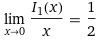

Source: https://www.mathworks.com/help/matlab/ref/besseli.html
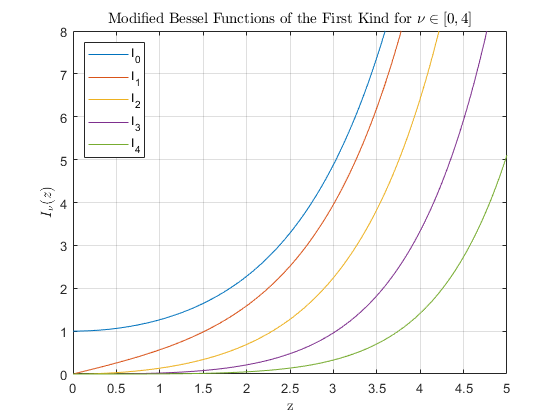

Misra, D.K. (2006). Appendix C: Bessel Functions. In Practical Electromagnetics, D.K. Misra (Ed.). https://doi-org.proxy2.library.illinois.edu/10.1002/9780470054208.app3

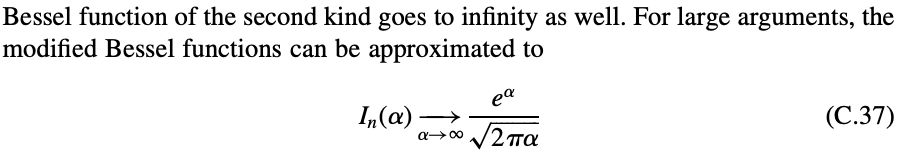


Zeros of Bessel’s Functions of the First Kind   

| # of Zeros |    J0(x) 	| J1(x)    	| J2(x)    	| J3(x)    	| J4(x)    	| J5(x)    	|
|-------------	|-----------------	|----------	|----------	|----------	|----------	|----------	|
|           1 	| 2.40483         	| 3.83171  	| 5.13562  	| 6.38016  	| 7.58834  	| 8.77148  	|
| 2           	| 5.52008         	| 7.01559  	| 8.41724  	| 9.76102  	| 11.06471 	| 12.3386  	|
| 3           	| 8.65373         	| 10.17347 	| 11.61984 	| 13.0152  	| 14.37254 	| 15.70017 	|
| 4           	| 11.79153        	| 13.32369 	| 14.79595 	| 16.22347 	| 17.61597 	| 18.98013 	|
| 5           	| 14.93092        	| 16.47063 	| 17.95982 	| 19.40941 	| 20.82693 	| 22.2178  	|

TABLE C.2 Zeros of the Derivatives of Bessel’s Functions of the First Kind

| Number of Zeros 	| J0'(x)   	| J1'(x)   	| J2'(x)   	| J3'(x)   	| J4'(x)   	| J5'(x)   	|
|-----------------	|----------	|----------	|----------	|----------	|----------	|----------	|
| 1               	| 3.83171  	| 1.84118  	| 3.05424  	| 4.20119  	| 5.31755  	| 6.41562  	|
| 2               	| 7.01559  	| 5.33144  	| 6.70613  	| 8.01524  	| 9.2824   	| 10.51986 	|
| 3               	| 10.17347 	| 8.53632  	| 9.96947  	| 11.34592 	| 12.68191 	| 13.98719 	|
| 4               	| 13.32369 	| 11.706   	| 13.17037 	| 14.58585 	| 15.96411 	| 17.31284 	|
| 5               	| 16.4706  	| 14.86359 	| 16.34752 	| 17.78875 	| 19.19603 	| 20.57551 	|

## https://functions.wolfram.com/Bessel-TypeFunctions/BesselI/introductions/Bessels/ShowAll.html

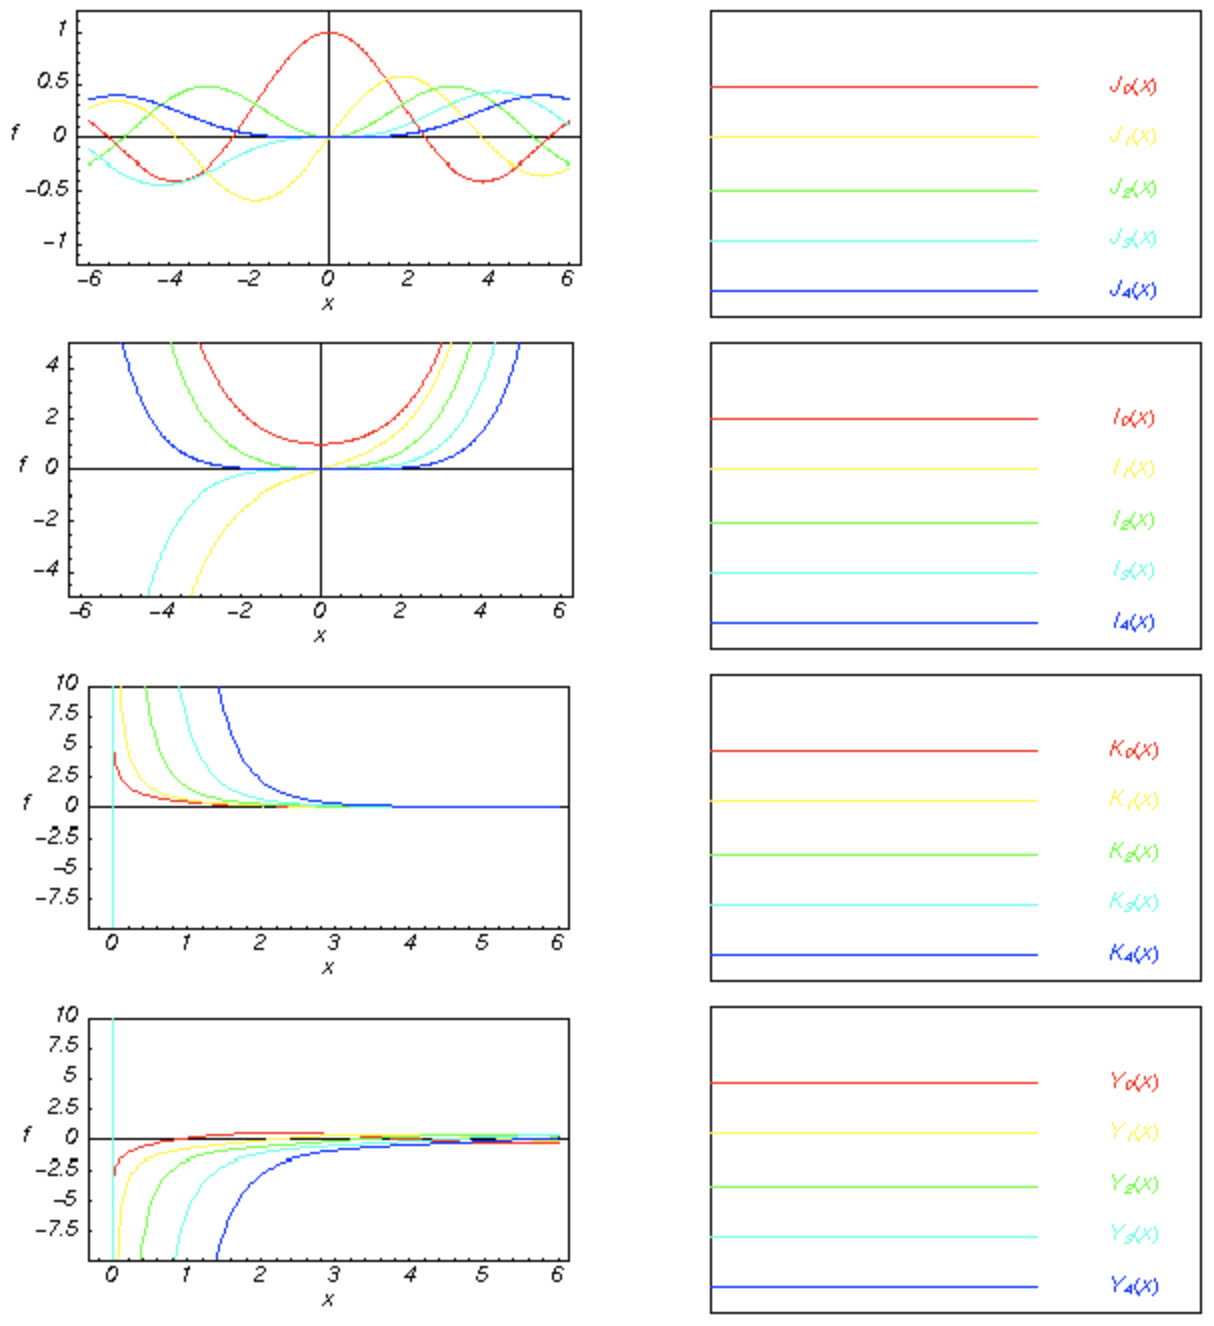

## Source: http://www.mhtlab.uwaterloo.ca/courses/me755/web_chap4.pdf

## Definitions .....................................................................

### 1. Bessel Equation

The second order differential equation given as

$x^2 \frac{d^2y}{dx^2} + x \frac{dy}{dx} + (x^2 - ν^2 )y=0$

is known as Bessel’s equation. Where the solution to Bessel’s equation yields Bessel functions of the first and second kind as follows:

$y=A J_ν(x)+B Y_ν(x)$

where $A$ and $B$ are arbitrary constants. While Bessel functions are often presented in text books and tables in the form of integer order, i.e. $ν=0, 1 , 2 ,...$, in fact they are defined for all real values of $−∞<ν<∞$.

### 2. Bessel Functions

a) First Kind: $Jν(x)$ in the solution to Bessel’s equation is referred to as a Bessel function of the first kind.

b) Second Kind: $Yν(x)$ in the solution to Bessel’s equation is referred to as a
Bessel function of the second kind or sometimes the Weber function or the
Neumann function.

b) Third Kind: The Hankel function or Bessel function of the third kind can be
written as


$Hν(1)(x)=Jν(x)+iYν(x), x> 0$  
$Hν(2)(x)=Jν(x)−iYν(x), x> 0$  


Because of the linear independence of the Bessel function of the first and second kind, the Hankel functions provide an alternative pair of solutions to the Bessel differential equation.

### 3. Modified Bessel Equation

By letting $x= ix$ (where $i=\sqrt{-1}$) in the Bessel equation we can obtain the modified Bessel equation of order ν, given as

$x^2 \frac{d^2y}{dx^2} + x \frac{dy}{dx}- (x^2 +ν^2 )y=0$


The solution to the modified Bessel equation yields modified Bessel functions of the first and second kind as follows:

$y=CIν(x)+DKν(x), x> 0$  

### 4. Modified Bessel Functions

a) First Kind: $Iν(x)$ in the solution to the modified Bessel’s equation is referred to as a modified Bessel function of the first kind.  

b) Second Kind: $Kν(x)$ in the solution to the modified Bessel’s equation is re-
ferred to as a modified Bessel function of the second kind or sometimes the
Weberfunction or the Neumann function.  


$I_0(x)=J_0(i \cdot x)$  
$I_1(x)=-i\cdot J_1(i \cdot x)$  
$I_2(x)=- J_2(i \cdot x)$  
$I_\nu(x)=i^{-\nu} \cdot J_\nu(i \cdot x)=J_\nu(i^{3/2} \cdot x)$   


## Derivative (Recurrence) Formulas of Bessel Functions

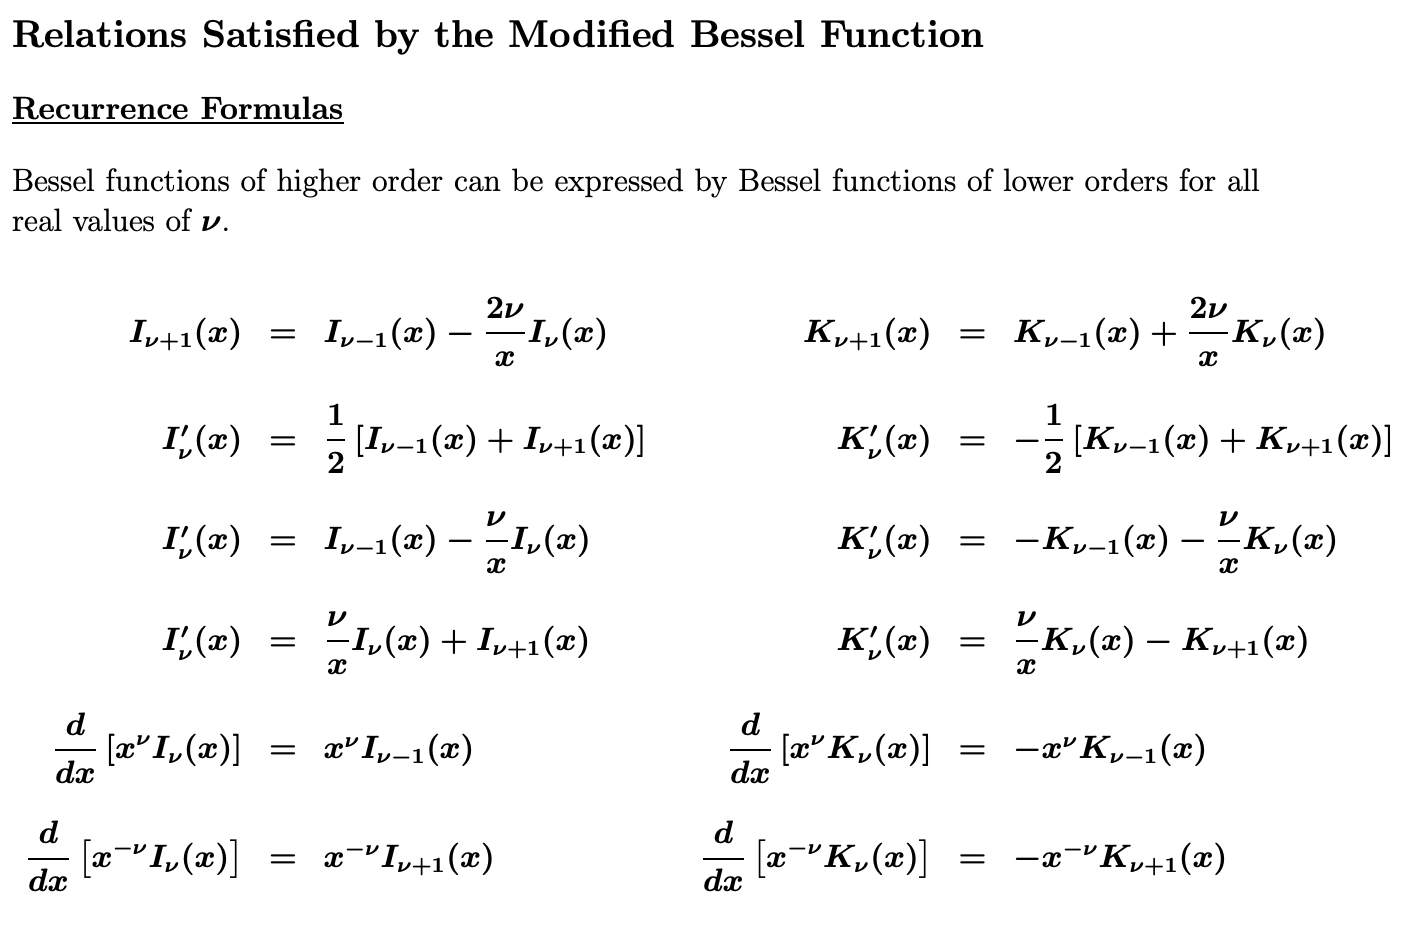

## Integral Definitions of Bessel functions
For integer orders $n=0,1,2,3...$
\begin{align}
I_n(x)&=\frac{1}{\pi} \int_0^\pi \cos{(n\theta)} \,\exp(x\cos{\theta})\, \mathrm{d}\theta  \\
I_0(x)&=\frac{1}{\pi} \int_0^\pi \exp(x\cos{\theta})\, \mathrm{d}\theta \\
I_1(x)&=\frac{1}{\pi} \int_0^\pi \cos{(\theta)} \, \exp(x\cos{\theta})\, \mathrm{d}\theta \\ 
I_0(x)&=\frac{1}{\pi} \int_0^\pi \cosh(x\cos{\theta})\, \mathrm{d}\theta \\
I_1(x)&= \dfrac{\mathrm{d}I_0(x)}{\mathrm{d}x}=\frac{1}{\pi} \int_0^\pi \cosh(x\cos{\theta})\, \mathrm{d}\theta \\
\end{align}

# Hyperbolic Trig Definitions
Source: https://en.wikipedia.org/wiki/Hyperbolic_functions#Exponential_definitions on 2021_07_13

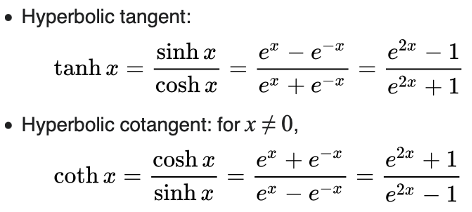